<a href="https://colab.research.google.com/github/ErwinTio/UAS-BIGDATA7DAT-MINING/blob/main/UAS%20BIGDATA%26DATAMINING%2022.11.4670.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Head:
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24

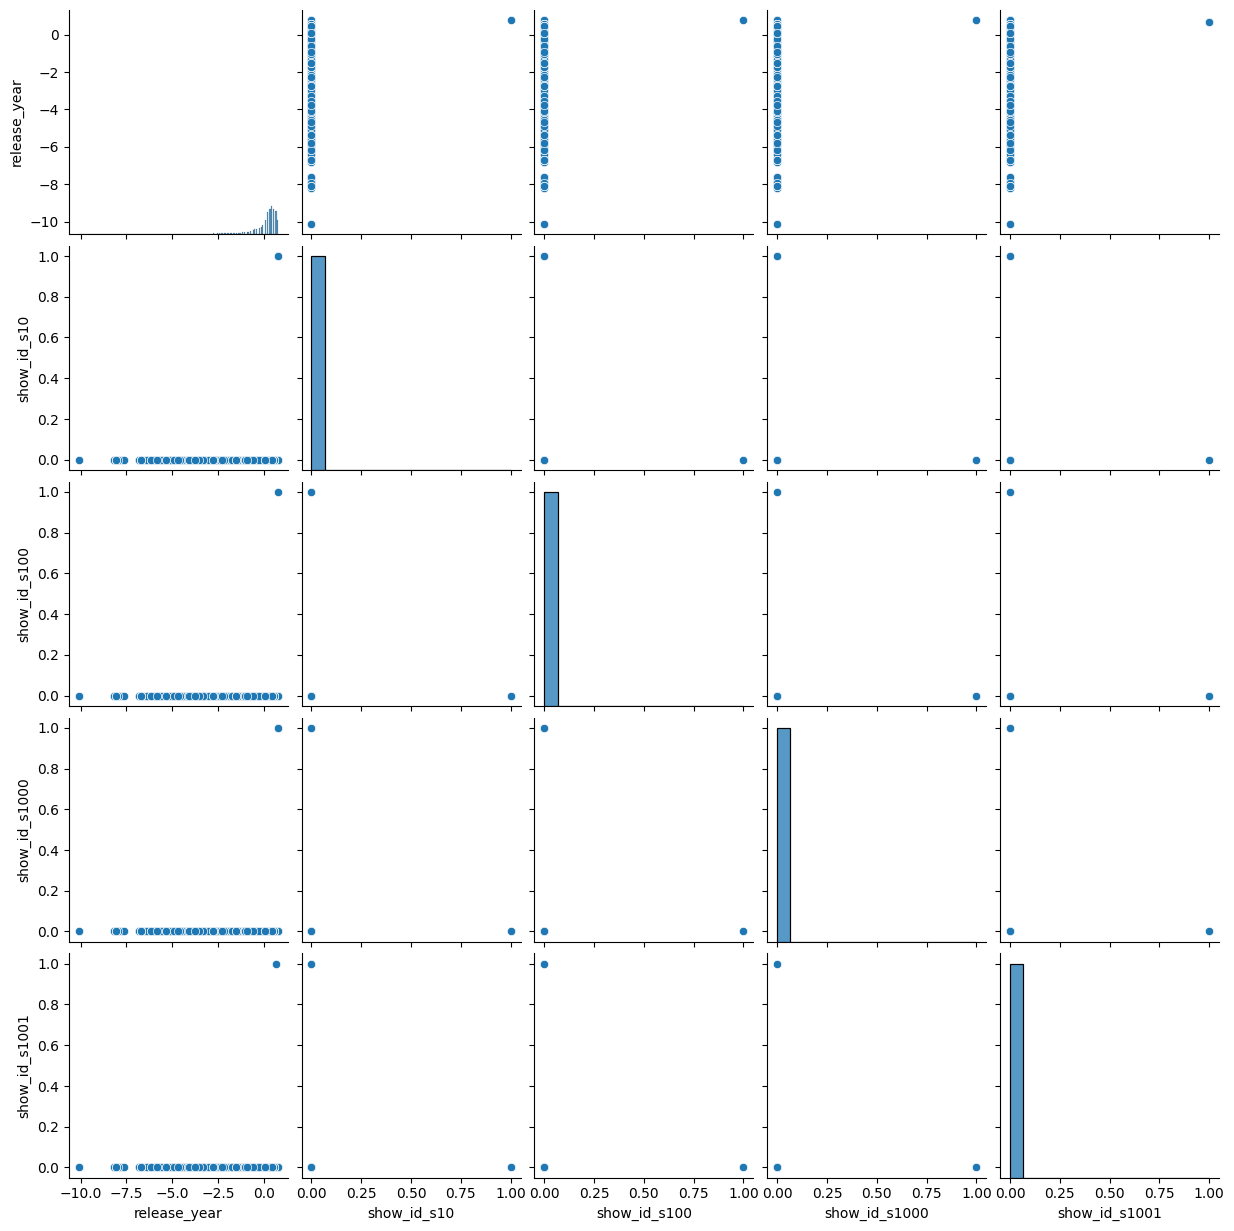

In [ ]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2

# 1. **LOAD DATASET**
# Gantikan path dengan lokasi dataset Netflix Anda.
data_path = '/content/netflix_titles.csv'
data = pd.read_csv(data_path)

# 2. **PROFILE DATASET**
# Melihat informasi awal tentang data
print("Dataset Head:")
print(data.head())
print("\nDataset Info:")
data.info()
print("\nMissing Values:")
print(data.isnull().sum())

# Deskripsi statistik
print("\nStatistical Description:")
print(data.describe())

# 3. **DATA PREPROCESSING**
# Mengatasi missing values
imputer = SimpleImputer(strategy='mean')  # Bisa diganti dengan 'median' atau 'most_frequent'
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

# Encoding untuk data kategorik
categorical_columns = data.select_dtypes(include=['object']).columns
# Remove the 'sparse' argument
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False) # handle_unknown added to handle unseen values during prediction,sparse=False to return array
categoricals_encoded = encoder.fit_transform(data[categorical_columns])
categoricals_encoded_df = pd.DataFrame(categoricals_encoded, columns=encoder.get_feature_names_out(categorical_columns))
# specify input_features to get_feature_names_out to avoid future warnings
# Menggabungkan data numerik dan kategorik yang sudah di-preprocessing
data = pd.concat([data[numeric_columns], categoricals_encoded_df], axis=1)
# Normalisasi/standarisasi data numerik
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# 4. **EXPLORATORY DATA ANALYSIS (EDA)**
# Visualisasi distribusi data
sns.pairplot(data.iloc[:, :5])  # Menggunakan 5 fitur pertama untuk contoh
plt.show()

# Heatmap korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# 5. **SELEKSI FITUR**
# Menggunakan SelectKBest untuk memilih fitur terbaik
X = data.drop('rating', axis=1)
y = data['rating']
selector = SelectKBest(score_func=chi2, k=10)  # Pilih 10 fitur terbaik
X_new = selector.fit_transform(X, y)

# Menampilkan fitur yang dipilih
selected_features = X.columns[selector.get_support(indices=True)]
print("Selected Features:", selected_features)

# 6. **MODELING**
# Split dataset menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Melatih model Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Menyimpan model
import joblib
joblib.dump(model, 'random_forest_model.pkl')

# 7. **EVALUASI MODEL**
# Prediksi pada data uji
y_pred = model.predict(X_test)

# Evaluasi model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Membuat figure dan subplots (dalam satu kolom)
fig, axes = plt.subplots(4, 1, figsize=(10, 24))

# 1. Grafik Distribusi Jenis Konten (Movie vs TV Show)
sns.countplot(x='type', data=data, palette='Set2', ax=axes[0])
axes[0].set_title('Distribusi Jenis Konten Netflix')
axes[0].set_xlabel('Jenis Konten')
axes[0].set_ylabel('Jumlah')

# 2. Grafik Distribusi Durasi Film (Untuk Tipe "Movie" Saja)
movies_data = data[data['type'] == 'Movie']
# movies_data['duration'] = movies_data['duration'].str.replace(' min', '').astype(int)  # Remove this line
sns.histplot(movies_data['duration'], bins=30, color='skyblue', kde=True, ax=axes[1]) # 'duration' is already numeric
axes[1].set_title('Distribusi Durasi Film Netflix')
axes[1].set_xlabel('Durasi (menit)')
axes[1].set_ylabel('Frekuensi')

# 3. Grafik Jumlah Film dan Acara TV per Tahun
data['release_year'] = data['release_year'].astype(int)
yearly_data = data.groupby(['release_year', 'type']).size().reset_index(name='count')
sns.lineplot(data=yearly_data, x='release_year', y='count', hue='type', marker='o', ax=axes[2])
axes[2].set_title('Jumlah Film dan Acara TV Netflix per Tahun')
axes[2].set_xlabel('Tahun')
axes[2].set_ylabel('Jumlah')

# 4. Grafik Distribusi Rating
sns.countplot(x='rating', data=data, palette='viridis', order=data['rating'].value_counts().index, ax=axes[3])
axes[3].set_title('Distribusi Rating untuk Film dan Acara TV Netflix')
axes[3].set_xlabel('Rating')
axes[3].set_ylabel('Jumlah')
axes[3].tick_params(axis='x', rotation=90)

# Menampilkan semua grafik dalam satu kolom
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Memuat dataset
file_path = "/content/netflix_titles.csv"
data = pd.read_csv(file_path)

# Menggunakan hanya data Movie dan membersihkan kolom 'duration'
movies_data = data[data['type'] == 'Movie'].copy()
movies_data['duration'] = movies_data['duration'].str.extract('(\d+)').astype(float)

# Menghapus baris dengan nilai NaN pada 'duration' atau 'release_year'
movies_data = movies_data.dropna(subset=['duration', 'release_year'])

# Fitur (release_year) dan Target (duration)
X = movies_data[['release_year']]
y = movies_data['duration']

# Split data untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Regresi
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluasi
mse = mean_squared_error(y_test, model.predict(X_test))
print(f'Mean Squared Error: {mse:.2f}')

# Prediksi untuk semua tahun yang unik
all_years = movies_data['release_year'].unique()
predictions = {}
for year in all_years:
    durasi_prediksi = model.predict(np.array([[year]]))[0]
    predictions[year] = durasi_prediksi

# Menampilkan hasil prediksi untuk semua tahun
for year, duration in predictions.items():
    print(f'Prediksi durasi untuk film yang dirilis pada tahun {year}: {duration:.2f} menit')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd # Import pandas to read the data

# Menyediakan path dataset setelah diunduh dari Kaggle
file_path = "/content/netflix_titles.csv"

# Memuat dataset
data = pd.read_csv(file_path) # Define 'data' before using it

# Menghitung jumlah rilis per tahun
time_series = data.groupby('release_year').size()

# Plot data time series
plt.figure(figsize=(12, 6))
plt.plot(time_series.index, time_series.values, marker='o', linestyle='-')
plt.title('Jumlah Rilis Konten Netflix per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Konten')
plt.grid(True)
plt.show()

In [ ]:
!pip install --upgrade mlxtend
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd

# Memuat dataset
file_path = "/content/netflix_titles.csv"
data = pd.read_csv(file_path)

# Memisahkan genre menjadi list, menangani nilai NaN
data['listed_in'] = data['listed_in'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# Membuat DataFrame one-hot encoding untuk genre
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit_transform(data['listed_in'].apply(lambda x: x if isinstance(x, list) else []))
df_genre = pd.DataFrame(te_ary, columns=te.columns_)

# Menjalankan algoritma Apriori
frequent_itemsets = apriori(df_genre, min_support=0.05, use_colnames=True)

# Mencari aturan asosiasi
# Added num_itemsets argument
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0, num_itemsets=frequent_itemsets.shape[0])


# Menampilkan hasil aturan asosiasi
print(rules.head())

In [ ]:
import pandas as pd
from google.colab import files # If using Google Colab

# Upload the file
uploaded = files.upload()

# Assuming the file is now uploaded
file_path = "/content/netflix_titles.csv"  # Or the correct path

# Load the dataset
data = pd.read_csv(file_path)

# Rest of your code...

# Menggunakan data film dengan durasi valid
movies_data = data[data['type'] == 'Movie'].dropna(subset=['duration'])
movies_data['duration'] = movies_data['duration'].str.replace(' min', '').astype(float)

# Menentukan fitur untuk clustering
X = movies_data[['release_year', 'duration']]

# Menentukan jumlah cluster (misalnya, 3 cluster)
kmeans = KMeans(n_clusters=3, random_state=42)
movies_data['cluster'] = kmeans.fit_predict(X)

# Visualisasi clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=movies_data['release_year'], y=movies_data['duration'], hue=movies_data['cluster'], palette='viridis')
plt.title('Clustering Konten Netflix berdasarkan Tahun dan Durasi')
plt.xlabel('Tahun Rilis')
plt.ylabel('Durasi (menit)')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Memuat dataset
file_path = "/content/netflix_titles.csv"
data = pd.read_csv(file_path)

# Memisahkan genre menjadi list, menangani nilai NaN
data['listed_in'] = data['listed_in'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# Membuat DataFrame dengan genre dan tahun rilis
genre_year_data = []
for index, row in data.iterrows():
    for genre in row['listed_in']:
        genre_year_data.append({'genre': genre, 'release_year': row['release_year']})

genre_year_df = pd.DataFrame(genre_year_data)

# Menghitung jumlah rilis per genre per tahun
genre_year_counts = genre_year_df.groupby(['genre', 'release_year']).size().reset_index(name='count')

# Memfilter genre dengan jumlah rilis minimal 100
filtered_genres = genre_year_counts.groupby('genre')['count'].sum().reset_index()
filtered_genres = filtered_genres[filtered_genres['count'] >= 100]['genre'].tolist()
genre_year_counts = genre_year_counts[genre_year_counts['genre'].isin(filtered_genres)]

# Visualisasi pola rilis berdasarkan genre
plt.figure(figsize=(15, 10))
sns.lineplot(data=genre_year_counts, x='release_year', y='count', hue='genre')
plt.title('Pola Rilis Konten Netflix Berdasarkan Genre (Minimal 100 Rilis)')
plt.xlabel('Tahun Rilis')
plt.ylabel('Jumlah Rilis')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()